In [1]:
import numpy as np
import numpy.ma as ma
import os
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import itertools
from matplotlib import gridspec

import sys
sys.path.append('/scratch9/mkron/software/DeepIceLearning/Plots')
import plot_functions_mk as pfmk
from fancy_plot_mk import *

/scratch9/mkron/software/DeepIceLearning/Plots/fancy_plot_mk.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib64/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib64/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/ga38tul/.local/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ga38tul/.local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ga38tul/.local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File 

In [2]:
DATA_DIR = "/scratch9/mkron/data/NN_out/run14/"
predictions_mctrue = pickle.load(file(os.path.join(DATA_DIR, 'prediction.pickle')))
epochs_acc_loss = np.delete(np.genfromtxt(os.path.join(DATA_DIR, "loss_logger.csv"), delimiter=','), 0, axis=0).T

In [3]:
def retag_classify(ClassLabel):
    ClassLabelRetag = ClassLabel
    ClassLabelRetag[ClassLabel == 0] =0
    ClassLabelRetag[ClassLabel == 1] =0
    ClassLabelRetag[ClassLabel == 2] =1
    ClassLabelRetag[ClassLabel == 3] =1
    ClassLabelRetag[ClassLabel == 4] =1
    ClassLabelRetag[ClassLabel == 5] =2
    ClassLabelRetag[ClassLabel == 6] =2
    ClassLabelRetag[ClassLabel == 7] =0
    ClassLabelRetag[ClassLabel == 8] =1
    ClassLabelRetag[ClassLabel == 9] =0
    return ClassLabelRetag

def acc_vs_hitDOMs_plot(pred, true, hitDOMs, title, binnumber):
    '''
    inputs:
    pred: predictions of the NN of the events
    true: integer - what should the NN predict - number of class
    energy: energys of the events
       
    '''

    was_NN_right = [] #was_NN_right: Mask with 1 if prediction was right, if not 0
    for i in xrange(0,len(pred)):
        if np.argmax(pred[i]) == true:
            was_NN_right.append(1)
        else:
            was_NN_right.append(0)


    bins = np.linspace(np.min(hitDOMs), np.max(hitDOMs), binnumber)
    valsTrue = np.histogram(hitDOMs, weights=was_NN_right, bins=bins)[0]
    valsAll = np.histogram(hitDOMs, bins=bins)[0]
    acc = 1.*valsTrue/valsAll


    plt.plot(bins[:-1], acc, "x")
    #plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.ylabel('accuracy', fontsize=16)
    plt.xlabel('number of hit DOMs', fontsize=16)

def summary_plot_binary_target(pred_target, MC_target, classes, energy, binnumber):

    # masking the lists to the labels
    pred_for_class1 = pred_target[MC_target == 0]
    E_for_class1 = energy[MC_target == 0]
    pred_for_class2 = pred_target[MC_target == 1]
    E_for_class2 = energy[MC_target == 1]

    # calculating values for the confusion matrix
    absolute, xe,ye = np.histogram2d(np.argmax(pred_target, axis=1), MC_target, bins=(len(classes),len(classes)))
    # that means that the prediction has to correspond to a event type 
    res_true = absolute/np.sum(absolute,axis=0)
    # normalization if the absolute values, so that the sum over PREDICTION is 1
    # that means that a event hast to be predicted as one type 
    res_pred = absolute/np.sum(absolute,axis=1).reshape(-1,1)

    # PLOT
    fig = plt.figure(figsize=(16, 16))
    ax1 = plt.subplot2grid((3, 2), (0, 0))
    ax1 = acc_vs_energy_plot(pred_for_class1, 0, E_for_class1, "Accuracy vs. Energy for class {}".format(classes[0]), binnumber)

    ax2 = plt.subplot2grid((3, 2), (0, 1))
    ax2 = acc_vs_energy_plot(pred_for_class2, 1, E_for_class2, "Accuracy vs. Energy for class {}".format(classes[1]), binnumber)

    ax3 = plt.subplot2grid((3, 2), (1, 0))
    bins = np.linspace(np.min(np.log10(E_for_class1)), np.max(np.log10(E_for_class1)), binnumber)
    valsAll = np.histogram(np.log10(E_for_class1), bins=bins)[0]
    ax3.semilogy(bins[:-1], valsAll, drawstyle = 'steps-mid')
    ax3.set_title("Statistic of {} Events vs. Energy".format(classes[0]), fontsize=16)
    ax3.set_xlabel('log_10(E) [GeV]', fontsize=16)
    ax3.set_ylabel('amount of events', fontsize=16)

    ax4 = plt.subplot2grid((3, 2), (1, 1))
    bins = np.linspace(np.min(np.log10(E_for_class2)), np.max(np.log10(E_for_class2)), binnumber)
    valsAll = np.histogram(np.log10(E_for_class2), bins=bins)[0]
    ax4.semilogy(bins[:-1], valsAll, drawstyle = 'steps-mid')
    ax4.set_title("Statistic of {} Events vs. Energy".format(classes[1]), fontsize=16)
    ax4.set_xlabel('log_10(E) [GeV]', fontsize=16)
    ax4.set_ylabel('amount of events', fontsize=16)

    ax5 = plt.subplot2grid((3, 2), (2, 0))
    plot_confusion_matrix(res_true, classes=classes, title='Confusion matrix normalized on MCTruth')

    ax6 = plt.subplot2grid((3, 2), (2, 1))
    plot_confusion_matrix(res_pred, classes=classes, title='Confusion matrix normalized on PREDICTION')

def plot_confusion_matrix(cm, classes,title="", cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=18)
    plt.yticks(tick_marks, classes, fontsize=18)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(len(classes)), range(len(classes))):
        plt.text(j, i, '{:.2f}'.format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=14)

    plt.ylabel('Predicted label', fontsize=18)
    plt.xlabel('True label', fontsize=18)
    #plt.tight_layout()
    #plt.show()


def acc_vs_energy_plot(pred, true, energy, title, binnumber):
    '''
    inputs:
    pred: predictions of the NN of the events
    true: integer - what should the NN predict - number of class
    energy: energys of the events
       
    '''
    was_NN_right = [] #was_NN_right: Mask with 1 if prediction was right, if not 0
    for i in xrange(0,len(pred)):
        if np.argmax(pred[i]) == true:
            was_NN_right.append(1)
        else:
            was_NN_right.append(0)

    bins = np.linspace(np.min(np.log10(energy)), np.max(np.log10(energy)), binnumber)
    valsTrue = np.histogram(np.log10(energy), weights=was_NN_right, bins=bins)[0]
    valsAll = np.histogram(np.log10(energy), bins=bins)[0]
    acc = 1.*valsTrue/valsAll

    plt.plot(bins[:-1], acc, "x")
    #plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.ylabel('accuracy', fontsize=16)
    plt.xlabel('log_{10}(E) [GeV]', fontsize=16)

def acc_loss_plot(acc_train, loss_train, acc_val, loss_val, title):
    x = np.linspace(1, len(acc_train), num=len(acc_train), endpoint=True)
    plt.plot(x, acc_train, color="#0099cc", label="acc of the training set")
    plt.plot(x, loss_train, color='#35bcf8', label="loss of the training set")
    plt.plot(x, acc_val, color='#6c1ba1', label="acc of the validation set")
    plt.plot(x, loss_val, color='#af27cd', label="loss of the validation set")
    plt.title(title, fontsize=18)
    #plt.set_ylim(0., 1.8)
    plt.legend(bbox_to_anchor=(0.59, 0.97), loc=2, borderaxespad=0.)
    plt.ylabel('loss & percentage', fontsize=16)
    plt.xlabel("epochs", fontsize=16)

def acc_of_classifier_vs_x(pred, true, x, title, xlabel, ylabel, binnumber):
    '''
    inputs:
    pred: predictions of the NN of the events
    true: integer - what should the NN predict - number of class
    energy: energys of the events
       
    '''
    was_classifier_right = [] #was_NN_right: Mask with 1 if prediction was right, if not 0
    for i in xrange(0,len(pred)):
        if np.argmax(pred[i]) == true[i]:
            was_classifier_right.append(1)
        else:
            was_classifier_right.append(0)
            
    
    bins = np.linspace(np.min(x), np.max(x), binnumber)
    valsTrue = np.histogram(x, weights=was_classifier_right, bins=bins)[0]
    valsAll = np.histogram(x, bins=bins)[0]
    acc = 1.*valsTrue/valsAll

    plt.plot(bins[:-1], acc, "x")
    #plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

In [4]:
#Target 1
acc_train_1 = epochs_acc_loss[1]
loss_train_1 = epochs_acc_loss[2]
acc_val_1 = epochs_acc_loss[8]
loss_val_1 = epochs_acc_loss[9]
pred_label_1 = predictions_mctrue["prediction"][0] #list with probability for each class
true_label_1 = predictions_mctrue["mc_truth"]["ClassificationLabel_truth"][:len(pred_label_1)]
# ReTag ClassLabel to Labels which can be predicted
true_label_1 = retag_classify(true_label_1)

#Target 2
acc_train_2 = epochs_acc_loss[3]
loss_train_2 = epochs_acc_loss[4]
acc_val_2 = epochs_acc_loss[10]
loss_val_2 = epochs_acc_loss[11]
pred_label_2 = predictions_mctrue["prediction"][1] #list with probability for each class
true_label_2 = predictions_mctrue["mc_truth"]["StartingLabel_truth"][:len(pred_label_2)]


#Target 3
acc_train_3 = epochs_acc_loss[5]
loss_train_3 = epochs_acc_loss[6]
acc_val_3 = epochs_acc_loss[12]
loss_val_3 = epochs_acc_loss[13]
pred_label_3 = predictions_mctrue["prediction"][2] #list with probability for each class
true_label_3 = predictions_mctrue["mc_truth"]["UpDownLabel_truth"][:len(pred_label_3)]


#Energy
energy=[]
for i in xrange(0, len(pred_label_1)):
    energy.append(predictions_mctrue["reco_vals"][i][0])
energy = np.array(energy)

# Number of hit DOMs
hitDOMs = predictions_mctrue["HitDOMs"][:len(pred_label_1)]
hitDOMs = np.array(hitDOMs)

#Zenith
zenith=[]
for i in xrange(0, len(pred_label_1)):
    zenith.append(predictions_mctrue["reco_vals"][i][4])
zenith = np.array(zenith)

###### Allocation of variables

## Acc and Loss for different Targets

/home/ga38tul/.local/lib/python2.7/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


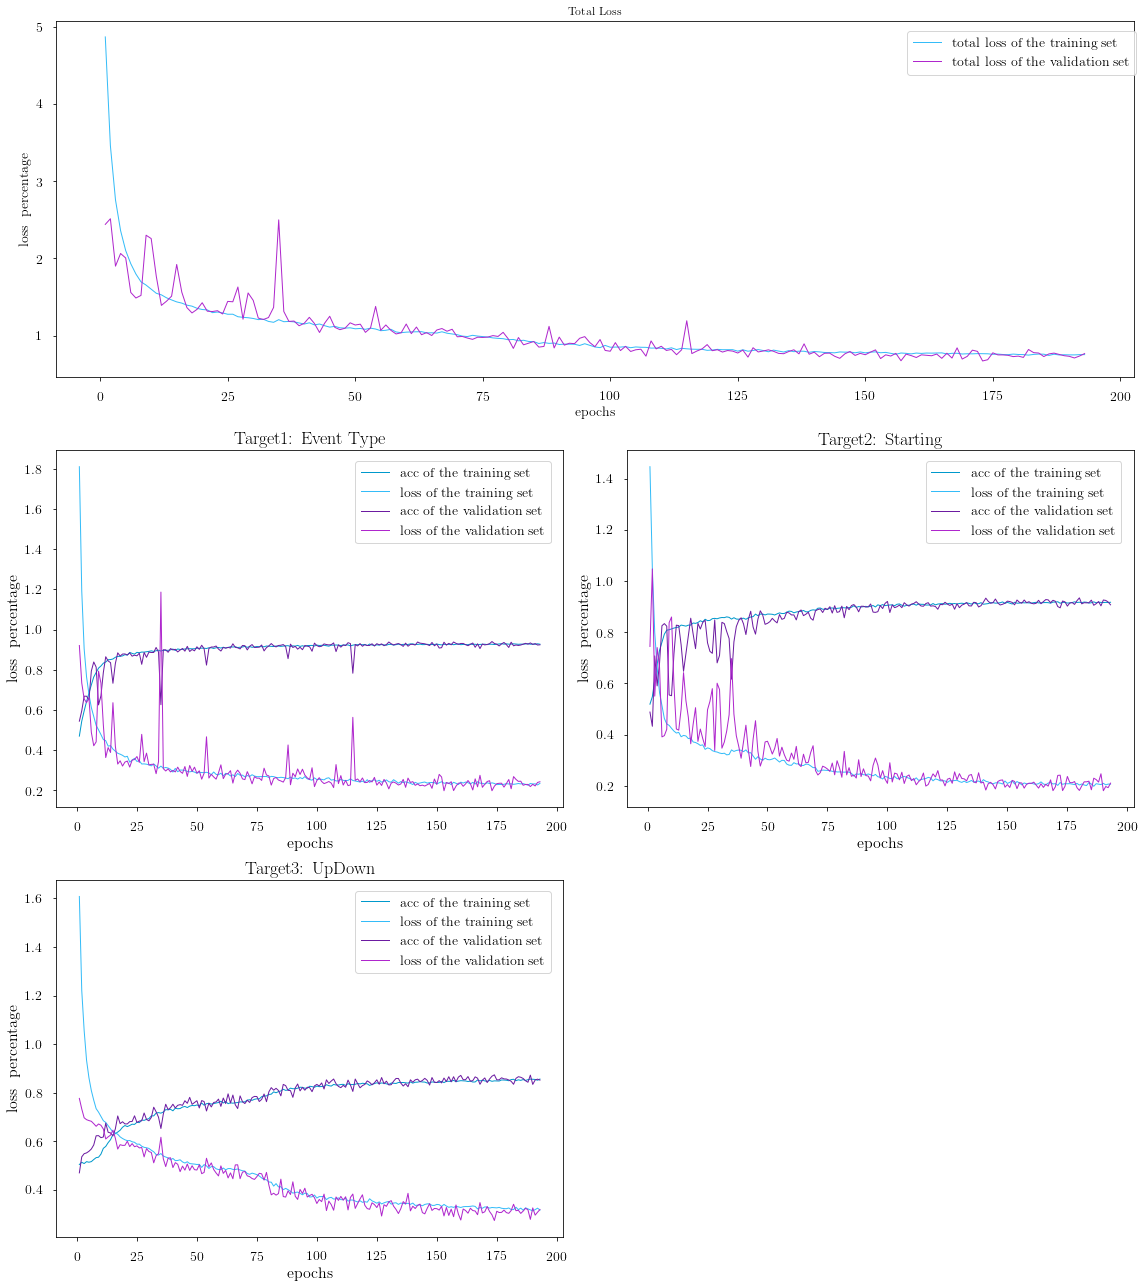

In [5]:
fig = plt.figure(figsize=(16,18))

ax0 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
x = np.linspace(1, len(epochs_acc_loss[0]), num=len(epochs_acc_loss[0]), endpoint=True)
ax0.plot(x, epochs_acc_loss[7], color="#35bcf8", label="total loss of the training set")
ax0.plot(x, epochs_acc_loss[14], color='#af27cd', label="total loss of the validation set")
ax0.legend(bbox_to_anchor=(0.79, 0.97), loc=2, borderaxespad=0.)
ax0.set_ylabel('loss & percentage')
ax0.set_xlabel("epochs")
ax0.set_title("Total Loss")

ax1 = plt.subplot2grid((3, 2), (1, 0), colspan=1)
ax1 = acc_loss_plot(acc_train_1, loss_train_1, acc_val_1, loss_val_1, "Target1: Event Type")

ax2 = plt.subplot2grid((3, 2), (1, 1), colspan=1)
ax2 = acc_loss_plot(acc_train_2, loss_train_2, acc_val_2, loss_val_2, "Target2: Starting")

ax3 = plt.subplot2grid((3, 2), (2, 0), colspan=1)
ax3 = acc_loss_plot(acc_train_3, loss_train_3, acc_val_3, loss_val_3, "Target3: UpDown")

In [6]:
# Identify the overall best run  
sum_acc_val = acc_val_1 + acc_val_2 + acc_val_3

print "ACC for the single Targets of the overall best epoch"
print "Acc on Validation Set of Target 1 Event Type : {}%".format(round(np.max(acc_val_1[np.argmax(sum_acc_val)])*100 ,2))
print "Acc on Validation Set of Target 2 Starting   : {}%".format(round(np.max(acc_val_2[np.argmax(sum_acc_val)])*100 ,2))
print "Acc on Validation Set of Target 3 UpDown: {}%".format(round(np.max(acc_val_3[np.argmax(sum_acc_val)])*100 ,2))

print np.argmax(sum_acc_val)

ACC for the single Targets of the overall best epoch
Acc on Validation Set of Target 1 Event Type : 94.0%
Acc on Validation Set of Target 2 Starting   : 92.17%
Acc on Validation Set of Target 3 UpDown: 86.78%
172


In [7]:
print "Max ACC of the single Targets, not neccesaryly in the same epoch"
print "Acc on Validation Set of Target 1 Event Type : {}%".format(round(np.max(acc_val_1)*100 ,2))
print "Acc on Validation Set of Target 2 Starting   : {}%".format(round(np.max(acc_val_2)*100 ,2))
print "Acc on Validation Set of Target 3 UpDown: {}%".format(round(np.max(acc_val_3)*100 ,2))

Max ACC of the single Targets, not neccesaryly in the same epoch
Acc on Validation Set of Target 1 Event Type : 94.0%
Acc on Validation Set of Target 2 Starting   : 93.39%
Acc on Validation Set of Target 3 UpDown: 87.33%


## Target 1 : Event Type

In [8]:
all_pred = np.argmax(pred_label_1, axis=1) # all predictions
pred_for_class1 = pred_label_1[true_label_1 == 0]  # predictions for the true cascades
E_for_class1 = energy[true_label_1 == 0]
pred_for_class2 = pred_label_1[true_label_1 == 1]
E_for_class2 = energy[true_label_1 == 1]
pred_for_class3 = pred_label_1[true_label_1 == 2]
E_for_class3 = energy[true_label_1 == 2]
hitDOMs_for_class1 = hitDOMs[true_label_1 == 0]
hitDOMs_for_class2 = hitDOMs[true_label_1 == 1]
hitDOMs_for_class3 = hitDOMs[true_label_1 == 2]

classes = ("Cascade", "Track", "Double Bang")

xedges = [-0.5, 0.5, 1.5, 2.5]
yedges = [-0.5, 0.5, 1.5, 2.5]
absolute, xe,ye = np.histogram2d(all_pred, true_label_1, bins=(xedges, yedges))
#print absolute

res_true = absolute/np.sum(absolute,axis=0)
# normalization if the absolute values, so that the sum over PREDICTION is 1
# that means that a event hast to be predicted as one type 
res_pred = absolute/np.sum(absolute,axis=1).reshape(-1,1)

/home/ga38tul/.local/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in divide


/home/ga38tul/.local/lib/python2.7/site-packages/ipykernel_launcher.py:132: RuntimeWarning: invalid value encountered in divide
/home/ga38tul/.local/lib/python2.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in divide


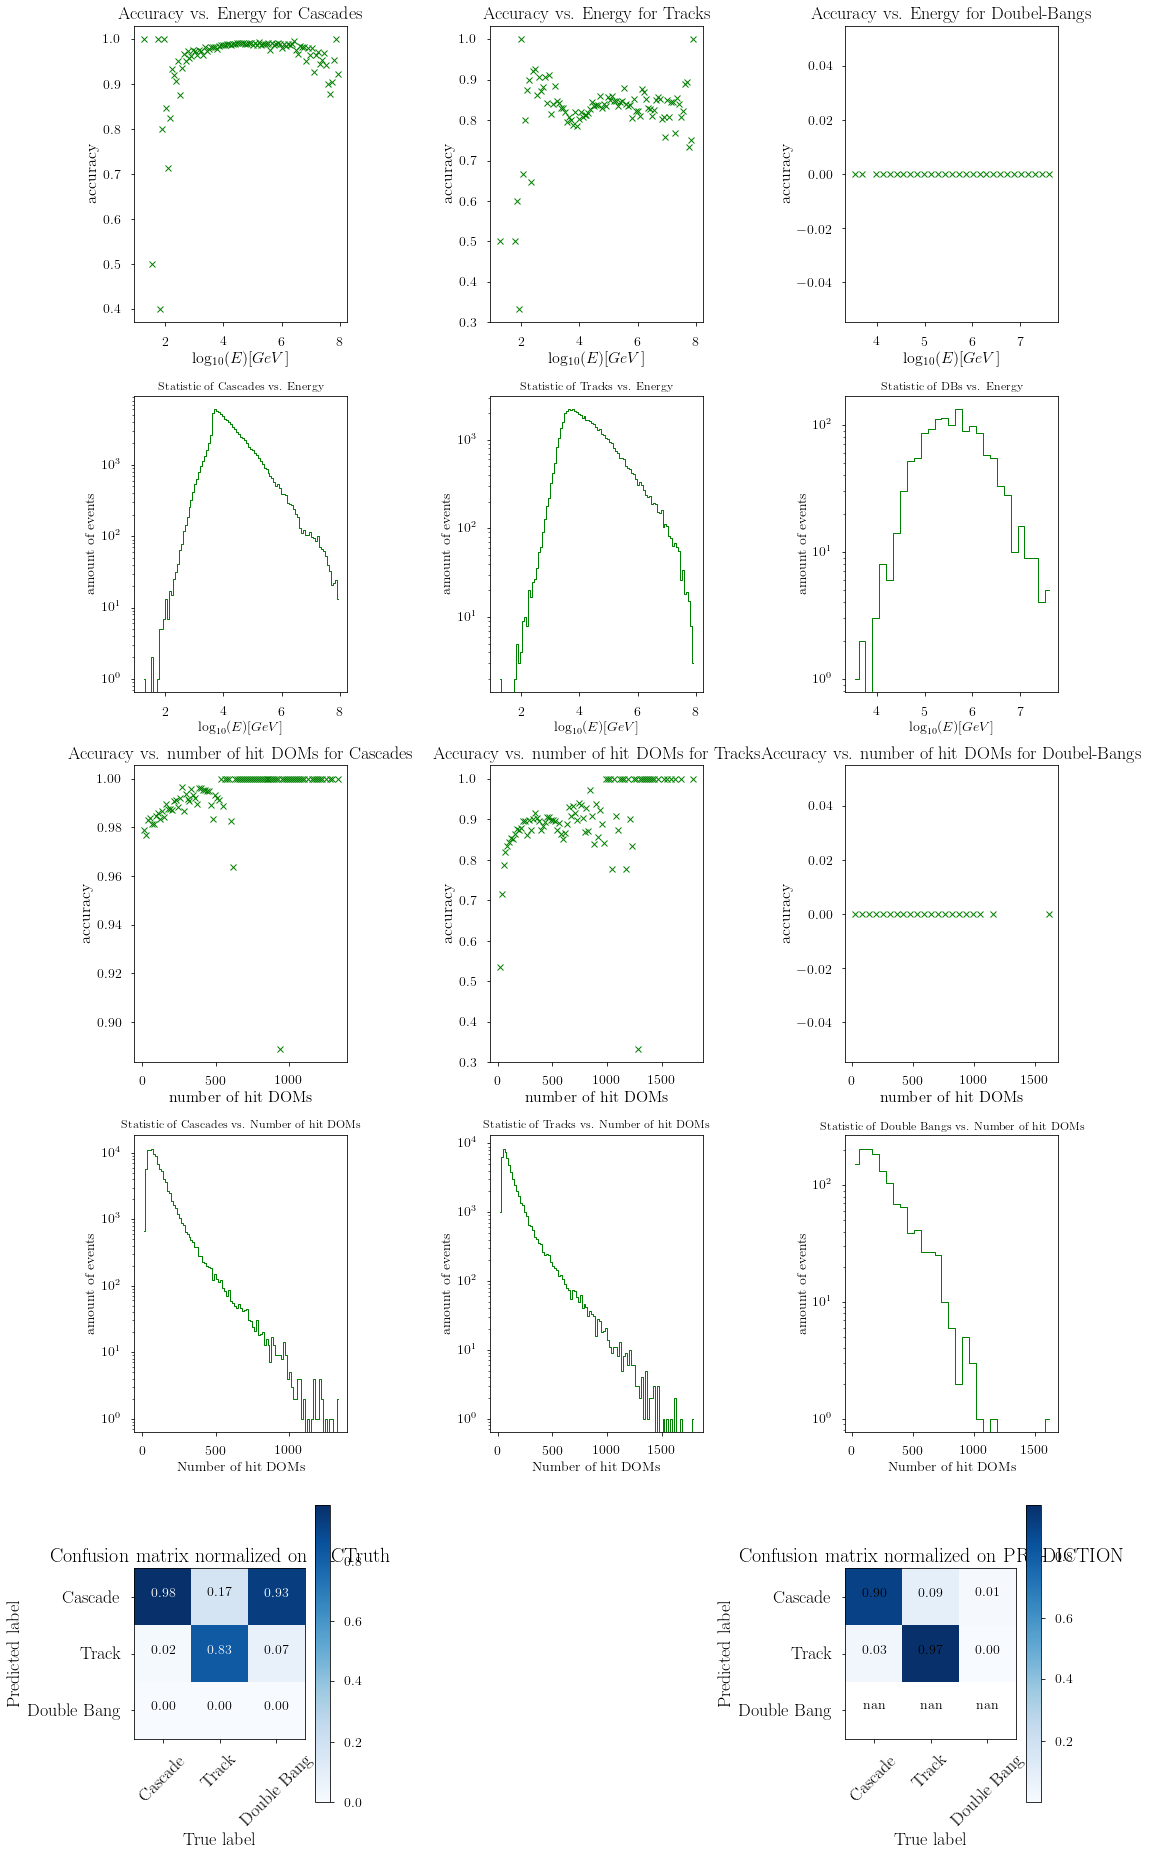

In [9]:
fig = plt.figure(figsize=(16, 26))

ax1 = plt.subplot2grid((5, 3), (0, 0))
ax1 = acc_vs_energy_plot(pred_for_class1, 0, E_for_class1, "Accuracy vs. Energy for Cascades", 100)

ax2 = plt.subplot2grid((5, 3), (0, 1))
ax2 = acc_vs_energy_plot(pred_for_class2, 1, E_for_class2, "Accuracy vs. Energy for Tracks", 100)

ax3 = plt.subplot2grid((5, 3), (0, 2))
ax3 = acc_vs_energy_plot(pred_for_class3, 2, E_for_class3, "Accuracy vs. Energy for Doubel-Bangs", 30)

ax4 = plt.subplot2grid((5, 3), (1, 0))
bins = np.linspace(np.min(np.log10(E_for_class1)), np.max(np.log10(E_for_class1)), 100)
valsAll = np.histogram(np.log10(E_for_class1), bins=bins)[0]
ax4.semilogy(bins[:-1], valsAll, drawstyle = 'steps-mid')
ax4.set_title("Statistic of Cascades vs. Energy")
ax4.set_xlabel('log_{10}(E) [GeV]')
ax4.set_ylabel('amount of events')

ax5 = plt.subplot2grid((5, 3), (1, 1))
bins = np.linspace(np.min(np.log10(E_for_class2)), np.max(np.log10(E_for_class2)), 100)
valsAll = np.histogram(np.log10(E_for_class2), bins=bins)[0]
ax5.semilogy(bins[:-1], valsAll, drawstyle = 'steps-mid')
ax5.set_title("Statistic of Tracks vs. Energy")
ax5.set_xlabel('log_{10}(E) [GeV]')
ax5.set_ylabel('amount of events')

ax6 = plt.subplot2grid((5, 3), (1, 2))
bins = np.linspace(np.min(np.log10(E_for_class3)), np.max(np.log10(E_for_class3)), 30)
valsAll = np.histogram(np.log10(E_for_class3), bins=bins)[0]
ax6.semilogy(bins[:-1], valsAll, drawstyle = 'steps-mid')
ax6.set_title("Statistic of DBs vs. Energy")
ax6.set_xlabel('log_{10}(E) [GeV]')
ax6.set_ylabel('amount of events')

ax7 = plt.subplot2grid((5, 3), (2, 0))
ax7 = acc_vs_hitDOMs_plot(pred_for_class1, 0, hitDOMs_for_class1, "Accuracy vs. number of hit DOMs for Cascades", 100)

ax8 = plt.subplot2grid((5, 3), (2, 1))
ax8 = acc_vs_hitDOMs_plot(pred_for_class2, 1, hitDOMs_for_class2, "Accuracy vs. number of hit DOMs for Tracks", 100)

ax9 = plt.subplot2grid((5, 3), (2, 2))
ax9 = acc_vs_hitDOMs_plot(pred_for_class3, 2, hitDOMs_for_class3, "Accuracy vs. number of hit DOMs for Doubel-Bangs", 30)

ax10 = plt.subplot2grid((5, 3), (3, 0))
bins = np.linspace(np.min(hitDOMs_for_class1), np.max(hitDOMs_for_class1), 100)
valsAll = np.histogram(hitDOMs_for_class1, bins=bins)[0]
ax10.semilogy(bins[:-1], valsAll, drawstyle = 'steps-mid')
ax10.set_title("Statistic of Cascades vs. Number of hit DOMs")
ax10.set_xlabel('Number of hit DOMs')
ax10.set_ylabel('amount of events')

ax11= plt.subplot2grid((5, 3), (3, 1))
bins = np.linspace(np.min(hitDOMs_for_class2), np.max(hitDOMs_for_class2), 100)
valsAll = np.histogram(hitDOMs_for_class2, bins=bins)[0]
ax11.semilogy(bins[:-1], valsAll, drawstyle = 'steps-mid')
ax11.set_title("Statistic of Tracks vs. Number of hit DOMs")
ax11.set_xlabel('Number of hit DOMs')
ax11.set_ylabel('amount of events')

ax12= plt.subplot2grid((5, 3), (3, 2))
bins = np.linspace(np.min(hitDOMs_for_class3), np.max(hitDOMs_for_class3), 30)
valsAll = np.histogram(hitDOMs_for_class3, bins=bins)[0]
ax12.semilogy(bins[:-1], valsAll, drawstyle = 'steps-mid')
ax12.set_title("Statistic of Double Bangs vs. Number of hit DOMs")
ax12.set_xlabel('Number of hit DOMs')
ax12.set_ylabel('amount of events')

ax13 = plt.subplot2grid((5, 3), (4, 0))
pfmk.plot_confusion_matrix(res_true, classes=classes, title='Confusion matrix normalized on MCTruth')

ax14 = plt.subplot2grid((5, 3), (4, 2))
pfmk.plot_confusion_matrix(res_pred, classes=classes, title='Confusion matrix normalized on PREDICTION')

## Target 2: Starting

/home/ga38tul/.local/lib/python2.7/site-packages/ipykernel_launcher.py:132: RuntimeWarning: invalid value encountered in divide


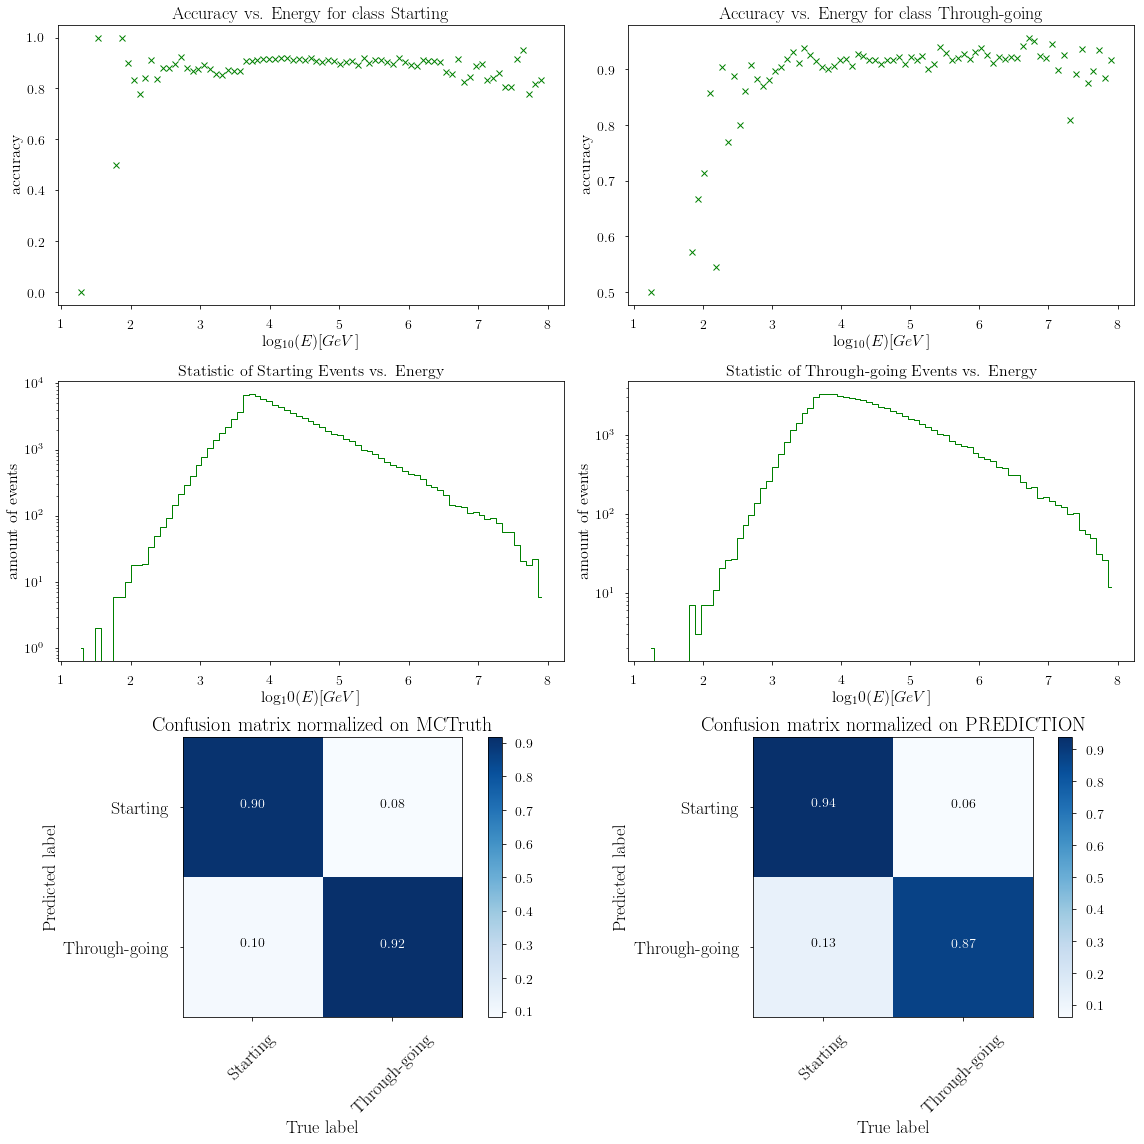

In [10]:
summary_plot_binary_target(pred_label_2, true_label_2, ("Starting", "Through-going"), energy, 80)

In [11]:
def acc_starting_event_type():
    

IndentationError: expected an indented block (<ipython-input-11-913d62c10b1e>, line 2)

In [ ]:
acc_vs_energy_plot_perType(pred_label_2[true_label_1 == 0], true_label_2[true_label_1 == 0], energy[true_label_1 == 0], "title", 100)
acc_vs_energy_plot_perType(pred_label_2[true_label_1 == 1], true_label_2[true_label_1 == 1], energy[true_label_1 == 1], "title", 100)

In [ ]:
#THEO PLOT STYLE
fig, ax1 = newfig(0.9)

x = np.linspace(1, len(epochs_acc_loss[0]), num=len(epochs_acc_loss[0]), endpoint=True)

ax1.legend(bbox_to_anchor=(0.975 , 0.3), ncol=2, borderaxespad=0.) #loc ='best'
ax1.set_title(r"XXX")#, fontsize=18)
ax1.set_xlabel(r'log_10(E) [GeV]')#, fontsize=16)
ax1.set_ylabel(r'accuracy')#, fontsize=16)
#ax1.set_ylim(-0.2, 1.05)

In [ ]:
def acc_vs_energy_plot_perType(pred, true, energy, title, binnumber):
    '''
    inputs:
    pred: predictions of the NN of the events
    true: integer - what should the NN predict - number of class
    energy: energys of the events
       
    '''
    was_NN_right = [] #was_NN_right: Mask with 1 if prediction was right, if not 0
    for i in xrange(0,len(pred)):
        if np.argmax(pred[i]) == true[i]:
            was_NN_right.append(1)
        else:
            was_NN_right.append(0)

    bins = np.linspace(np.min(np.log10(energy)), np.max(np.log10(energy)), binnumber)
    valsTrue = np.histogram(np.log10(energy), weights=was_NN_right, bins=bins)[0]
    valsAll = np.histogram(np.log10(energy), bins=bins)[0]
    acc = 1.*valsTrue/valsAll

    plt.plot(bins[:-1], acc, "x")
    #plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.ylabel()
    plt.xlabel()

## Target 3: UpDown-going

In [ ]:
#summary_plot_binary_target(pred_label_3, true_label_3, ("DOWN-going", "UP-going"), energy, 30)
print len(pred_label_3)

i=20820
print pred_label_3[i]
print np.argmax(pred_label_3[i])
print true_label_3[i]

In [ ]:
# plot acc vs zenith

#calc acc
wrong, right = 0,0
for i in xrange(len(pred_label_3)):
    if np.argmax(pred_label_3[i]) == true_label_3[i]:
        right +=1
    else:
        wrong +=1

print wrong
print right
print wrong+right
print len(pred_label_3)

In [ ]:
acc_of_classifier_vs_x(pred_label_3, true_label_3, np.cos(zenith), "Acc of UpDown-Classification depending on the zenith", "cos(zenith)", "accuracy", 100)
acc_of_classifier_vs_x(pred_label_3[true_label_1 == 0], true_label_3[true_label_1 == 0], np.cos(zenith[true_label_1 == 0]), "Acc of UpDown-Classification depending on the zenith", "cos(zenith)", "accuracy", 100)
acc_of_classifier_vs_x(pred_label_3[true_label_1 == 1], true_label_3[true_label_1 == 1], np.cos(zenith[true_label_1 == 1]), "Acc of UpDown-Classification depending on the zenith", "cos(zenith)", "accuracy", 100)

In [ ]:
acc_of_classifier_vs_x(pred_label_3[true_label_1 == 1], true_label_3[true_label_1 == 1], np.cos(zenith[true_label_1 == 1]), "Acc of UpDown-Classification depending on the zenith", "cos(zenith)", "accuracy", 100)

## Overall Performance

In [ ]:
def performence_target(pred, true):
    NN_correct = 0
    for i in xrange(len(true)):
        if np.argmax(pred[i]) == true[i]:
            NN_correct += 1
    return 1.*NN_correct/len(true)*100

In [ ]:
overall_performance = (performence_target(pred_label_1 , true_label_1)+performence_target(pred_label_2 , true_label_2)+performence_target(pred_label_3 , true_label_3)+performence_target(pred_label_4 , true_label_4))/4
print "Overall Performence: {}".format(overall_performance)
print "\n"
print "Event Typology: {}".format(performence_target(pred_label_1 , true_label_1))
print "Starting      : {}".format(performence_target(pred_label_2 , true_label_2))
print "Coincidence   : {}".format(performence_target(pred_label_3 , true_label_3))
print "UpDown        : {}".format(performence_target(pred_label_4 , true_label_4))

# possibility to claculate the acc for the target possibilities, for example acc for track


## Probabilitys of Predictions

In [13]:
def prob(pred, log, title):
    prob_cascade = []
    prob_track = []
    prob_db = []
    for i in xrange(len(pred)):
        prob_cascade.append(pred[i][0])
        prob_track.append(pred[i][1])
        prob_db.append(pred[i][2])

    bins = np.linspace(0, 1, 100)
    valsCascade = np.histogram(prob_cascade, bins=bins)[0]
    valsTrack = np.histogram(prob_track, bins=bins)[0]
    valsDB = np.histogram(prob_db, bins=bins)[0]
    
    if log:
        plt.semilogy(bins[:-1], valsCascade, drawstyle = 'steps-mid', label="Cascade")
        plt.semilogy(bins[:-1], valsTrack, drawstyle = 'steps-mid', label="Tracks")
        plt.semilogy(bins[:-1], valsDB, drawstyle = 'steps-mid', label="Double Bangs")
    else:
        plt.plot(bins[:-1], valsCascade, drawstyle = 'steps-mid', label="Cascade")
        plt.plot(bins[:-1], valsTrack, drawstyle = 'steps-mid', label="Tracks")
        plt.plot(bins[:-1], valsDB, drawstyle = 'steps-mid', label="Double Bangs")
    plt.legend(loc='best')

    plt.title(title)
    plt.ylabel("Counts")
    plt.xlabel("Probability")

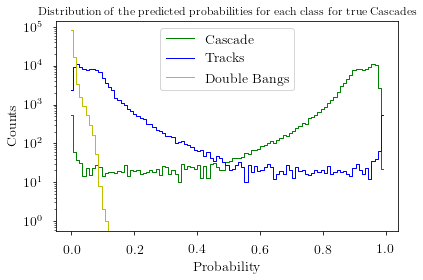

In [14]:
prob(pred_label_1[true_label_1 == 0], log=True, title="Distribution of the predicted probabilities for each class for true Cascades")

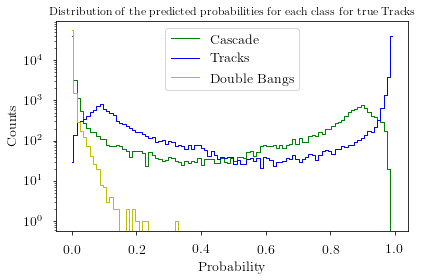

In [15]:
prob(pred_label_1[true_label_1 == 1], log=True, title="Distribution of the predicted probabilities for each class for true Tracks")

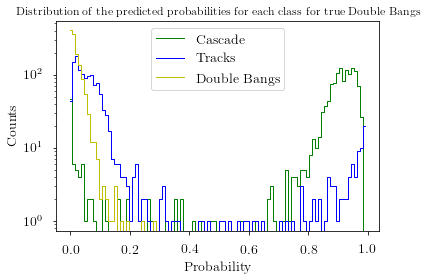

In [16]:
prob(pred_label_1[true_label_1 == 2], log=True, title="Distribution of the predicted probabilities for each class for true Double Bangs")